# **Scraping AloDokter App Reviews**

**Nama**  : Anak Agung Istri Istadewanti

**NRP**     : 5026211143

**Kelas** : PBA (A)



---
**INA v.3** adalah versi di mana analisis sentimen untuk review AloDokter di Google Play Store Berbahasa Indonesia dilakukan **menggunakan IndoBERT dengan proses fine-tuning**.

Data yang digunakan untuk *training* terdiri dari 120 data, sedangkan untuk *testing* adalah 30 data. Tingkat akurasi model yang diperoleh adalah **63,33%**. Model tersebut kemudian digunakan untuk melakukan labeling terhadap 3.000 data lainnya.


---





# SET UP

In [1]:
# Install libraries
!pip install google_play_scraper
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.2/553.2 kB 8.4 MB/s eta 0:00:00


In [2]:
# Import Libraries
# Standard libraries
import os
import time
import datetime
import re
from pathlib import Path
from PIL import Image

# Data handling and visualization libraries
import pandas as pd
import numpy as np
import regex as re
import nltk
import string
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates

# Machine learning and NLP libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from google_play_scraper import app, Sort, reviews, reviews_all
from copy import deepcopy
from IPython.display import clear_output
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Matplotlib Configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15, 10)

print("Libraries imported successfully.")

Libraries imported successfully.


<ipython-input-2-b8a24b1084b5>:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Scraping App Reviews


* Nama aplikasi yang akan di-*scraping* *review*-nya pada Google Play adalah **Alodokter —Chat Bersama Dokter**

*   Link App Android dari AloDokter pada Google Play:
https://play.google.com/store/apps/details?id=com.alodokter.android&hl=id
*   ID aplikasi AloDokter adalah `id=com.alodokter.android`
* Pada tanggal 07 September, jumlah review aplikasi pada Google Play adalah **458 ribu**.






In [ ]:
# Mengambil review aplikasi Alodokter dari Google Play Store

# Fungsi untuk mengambil jumlah review berdasarkan yang diinginkan
def scrap_alodokter_reviews(
    app_id='com.alodokter.android',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    total_reviews=25000,
    filter_score_with=None,
    filter_device_with=None
) -> list:
    # Mengambil batch pertama dari 100 review
    all_result, review_token = reviews(
        app_id,
        lang=lang,
        country=country,
        sort=sort,
        count=100,
        filter_score_with=filter_score_with,
        filter_device_with=filter_device_with,
        continuation_token=None  # Batch pertama, tanpa token kelanjutan
    )

    # Menghitung berapa kali kita perlu mengulang pengambilan data (25.000 / 100 = 250 kali)
    multiples = int(total_reviews / 100 - 1)
    print(f"Total reviews: {len(all_result)}/{total_reviews}")

    # Proses pengambilan batch selanjutnya hingga mencapai total_reviews yang diinginkan
    for i in range(multiples):
        result = []
        iterate_status = True
        token = deepcopy(review_token)  # Menyimpan token untuk batch berikutnya
        while iterate_status:
            result, review_token = reviews(app_id, continuation_token=token)
            if review_token.token:
                iterate_status = False
        for review in result:
            all_result.append(review)
        clear_output(wait=True)  # Membersihkan output untuk memantau progress
        print(f"Total reviews: {len(all_result)}/{total_reviews}")

    return all_result

# Mengambil 25.000 review
alodokter_reviews = scrap_alodokter_reviews(total_reviews=25000)

Total reviews: 25000/25000


In [ ]:
# Simpan review ke dalam DataFrame
df_alodokter = pd.DataFrame(np.array(alodokter_reviews), columns=['content'])
df_alodokter = df_alodokter.join(pd.DataFrame(df_alodokter.pop('content').tolist()))
df_alodokter.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c73502d6-5eda-4d28-9d92-a81fcd462873,Teguh Waluyo,https://play-lh.googleusercontent.com/a/ACg8oc...,dokternya ramah dan jelas,5,0,6.8.0,2024-09-08 15:14:04,None,NaT,6.8.0
1,e5a8dd88-00be-49ec-9b04-a95c0b06bae9,Iis Lumaksono,https://play-lh.googleusercontent.com/a/ACg8oc...,"cepat, tegas, ringkas.. terima kasih",5,0,6.8.0,2024-09-08 13:19:23,None,NaT,6.8.0
2,f4f48e92-f995-459a-9f85-6735f2965ac2,Riyans,https://play-lh.googleusercontent.com/a-/ALV-U...,Diluar dari apk nya yang sudah cukup bagus tam...,2,0,6.8.0,2024-09-08 10:51:29,None,NaT,6.8.0
3,acc83012-3329-4d1d-a15f-fe36a61cdbe9,Hery Nuel,https://play-lh.googleusercontent.com/a/ACg8oc...,"baik banget,dan ramah",5,0,6.4.0,2024-09-08 08:41:49,None,NaT,6.4.0
4,b5bc60b8-c9c0-4e50-8dc4-e61244d3fa73,Fifiana Fifi,https://play-lh.googleusercontent.com/a-/ALV-U...,"Respon lama, nngu gak jawab2 akhir ny tinggal ...",1,0,6.8.0,2024-09-08 05:27:11,None,NaT,6.8.0


In [ ]:
# Menampilkan jumlah baris dan kolom DataFrame
print(f"Jumlah data yang telah di-scraping: {df_alodokter.shape[0]}")

Jumlah data yang telah di-scraping: 25000


In [ ]:
# Simpan DataFrame ke dalam file CSV di direktori saat ini
file_path = 'df_alodokter_reviews.csv'

# Simpan DataFrame ke dalam file CSV
df_alodokter.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_reviews.csv


## Labeling Data

Data yang telah dikumpulkan sebelumnya berjumlah 25.000 entri. Namun, tidak semua data tersebut akan digunakan untuk *training* dan *testing* dalam pembuatan model IndoBERT. Dalam kasus ini, hanya 150 data yang akan diambil, terdiri dari 50 data positif (label 0), 50 netral (label 1), dan 50 negatif (label 2), yang telah dilabeli secara manual menggunakan Excel.

In [3]:
# Upload dataset yang telah diberi label
from google.colab import files
uploaded = files.upload()

Saving AloDokter_Rev_FIX to AloDokter_Rev_FIX


In [4]:
# Baca dataset yang diambil
file_name = list(uploaded.keys())[0]
df_alodokter = pd.read_csv(file_name)
df_alodokter.head()

,label,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1,341b26e2-d6b1-46da-a3f6-490e68d7a59f,Kim Ryna,https://play-lh.googleusercontent.com/a-/ALV-U...,"Waktu pembayarannya cuma 30 detik, baru buka a...",3,0,3.3.2000,2021-07-26 5:44:29,NaN,NaN,3.3.2000
1,0,31f984a3-fa76-49f8-bbb1-8bab1b0c3f74,Rindy Rumengan,https://play-lh.googleusercontent.com/a/ACg8oc...,Dokter nya Ramah dan penjelasannya mudah dipahami,5,0,6.8.2000,2024-08-21 13:04:21,NaN,NaN,6.8.2000
2,2,cf982e5b-82a1-4a4c-9eb7-94db09408d8a,Cah Nangkod,https://play-lh.googleusercontent.com/a/ACg8oc...,CHAT DOKTER GA DIBALAS SUDAH BAYAR KITA RUGI U...,1,0,NaN,2024-08-09 1:24:21,"Alo, Cah Nangkod! Mohon maaf atas ketidaknyama...",2024-08-09 8:06:41,NaN
3,1,2159f742-dbd2-4612-b97a-05fddf6bf5b7,sudarwati Aryani,https://play-lh.googleusercontent.com/a/ACg8oc...,I didnt know how alodokter proses obatnya. Yan...,3,0,3.2.2000,2021-07-08 2:30:51,NaN,NaN,3.2.2000
4,1,2487ac0d-6f18-442c-890f-0603d45b78d2,Resi Novia,https://play-lh.googleusercontent.com/a-/ALV-U...,"Konsultasi gk ada yg gratis, dulu gratis tapi ...",3,0,3.0.0,2021-07-15 8:47:31,NaN,NaN,3.0.0


# Preprocessing Data

Sebelum menganalisis lebih lanjut, kita harus memahami tipe dan informasi lainnya terkait data yang telah kita miliki.

Dengan menggunakan fungsi `info`, dapat dilihat bahwa kolom "reviewCreatedVersion", "replyContent", "repliedAt", dan "appVersion" memiliki nilai null.

In [5]:
# Informasi terkait data
df_alodokter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   label                 150 non-null    int64 
 1   reviewId              150 non-null    object
 2   userName              150 non-null    object
 3   userImage             150 non-null    object
 4   content               150 non-null    object
 5   score                 150 non-null    int64 
 6   thumbsUpCount         150 non-null    int64 
 7   reviewCreatedVersion  126 non-null    object
 8   at                    150 non-null    object
 9   replyContent          46 non-null     object
 10  repliedAt             46 non-null     object
 11  appVersion            126 non-null    object
dtypes: int64(3), object(9)
memory usage: 14.2+ KB


Selanjutnya kita ingin melihat semua nilai unik dalam kolom 'reviewCreatedVersion' untuk mengetahui versi apa saja yang tersedia pada review app AloDokter yang telah kita ambil.

In [6]:
unique_versions = df_alodokter.reviewCreatedVersion.unique()
print("Versi Aplikasi yang Unik dalam Review:")
print(unique_versions)

num_unique_versions = df_alodokter.reviewCreatedVersion.nunique()
print(f"\nJumlah versi aplikasi dalam review yang diambil adalah: {num_unique_versions}")

Versi Aplikasi yang Unik dalam Review:
['3.3.2000' '6.8.2000' nan '3.2.2000' '3.0.0' '6.7.2000' '4.0.0'
 '6.4.2000' '3.9.2001' '6.1.2000' '6.5.2000' '6.6.2000' '6.3.2000'
 '4.3.2000' '3.4.2001' '3.8.2000' '3.7.2000' '6.4.2001' '6.2.2000'
 '3.6.2001' '1.8.2000' '4.4.2000' '5.5.2000']

Jumlah versi aplikasi dalam review yang diambil adalah: 22


## Menghapus Emoji

Dapat dilihat pada DataFrame di atas bahwa kolom "content" ada yang berisi emoji saja. Oleh karena itu, kita akan menghapus emoji yang terdapat pada kolom "content"

In [7]:
# Fungsi untuk menghapus emoji dan karakter khusus dari teks
# Source: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emojis(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Menghapus emoji dan simbol dari kolom 'content'
df_alodokter['content'] = df_alodokter['content'].apply(remove_emojis)

In [8]:
df_alodokter

,label,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1,341b26e2-d6b1-46da-a3f6-490e68d7a59f,Kim Ryna,https://play-lh.googleusercontent.com/a-/ALV-U...,"Waktu pembayarannya cuma 30 detik, baru buka a...",3,0,3.3.2000,2021-07-26 5:44:29,NaN,NaN,3.3.2000
1,0,31f984a3-fa76-49f8-bbb1-8bab1b0c3f74,Rindy Rumengan,https://play-lh.googleusercontent.com/a/ACg8oc...,Dokter nya Ramah dan penjelasannya mudah dipahami,5,0,6.8.2000,2024-08-21 13:04:21,NaN,NaN,6.8.2000
2,2,cf982e5b-82a1-4a4c-9eb7-94db09408d8a,Cah Nangkod,https://play-lh.googleusercontent.com/a/ACg8oc...,CHAT DOKTER GA DIBALAS SUDAH BAYAR KITA RUGI U...,1,0,NaN,2024-08-09 1:24:21,"Alo, Cah Nangkod! Mohon maaf atas ketidaknyama...",2024-08-09 8:06:41,NaN
3,1,2159f742-dbd2-4612-b97a-05fddf6bf5b7,sudarwati Aryani,https://play-lh.googleusercontent.com/a/ACg8oc...,I didnt know how alodokter proses obatnya. Yan...,3,0,3.2.2000,2021-07-08 2:30:51,NaN,NaN,3.2.2000
4,1,2487ac0d-6f18-442c-890f-0603d45b78d2,Resi Novia,https://play-lh.googleusercontent.com/a-/ALV-U...,"Konsultasi gk ada yg gratis, dulu gratis tapi ...",3,0,3.0.0,2021-07-15 8:47:31,NaN,NaN,3.0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
145,1,4ec77dc8-54ad-4cc7-a895-4a1201976a76,ONI TRESNIATI,https://play-lh.googleusercontent.com/a/ACg8oc...,Di usahakan pertanyaan di bolehkan lebih dari ...,3,0,3.8.2000,2021-12-12 8:16:01,NaN,NaN,3.8.2000
146,2,1b401b6d-ec18-4655-9515-5984fbae07b2,franky franky,https://play-lh.googleusercontent.com/a/ACg8oc...,Aplikasi brengsek. Orang lagi sakit malah pese...,1,0,6.8.2000,2024-09-03 6:16:04,"Alo, (franky franky)! Mohon maaf atas ketidakn...",2024-09-06 8:01:59,6.8.2000
147,0,aba30ea3-3a91-491d-a359-a6b5bd37421b,Vina Lay,https://play-lh.googleusercontent.com/a/ACg8oc...,dokternya sangat baik..informatif dan sangat m...,5,0,6.8.2000,2024-08-29 13:22:06,NaN,NaN,6.8.2000
148,1,07830ba1-613d-4b6e-874b-ff53e48ca137,Mar Dwi,https://play-lh.googleusercontent.com/a/ACg8oc...,Cara pengobatannya bagaimana belum ada solusinya,3,0,3.9.2001,2022-01-28 3:40:04,NaN,NaN,3.9.2001


## Menghapus Review yang Kosong

Menghapus emoji dan karakter spesial memungkinkan beberapa review menjadi kosong, sehingga kita harus mengecek dan menghapusnya bila ada.

In [9]:
# Menghapus review yang bernilai kosong
df_alodokter = df_alodokter[df_alodokter['content'] != '']

In [10]:
# Memeriksa apakah masih ada review kosong pada kolom 'content' atau tidak
df_alodokter[df_alodokter['content'] == '']

,label,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion


In [11]:
# Jumlah data setelah melakukan preprocessing
df_alodokter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   label                 150 non-null    int64 
 1   reviewId              150 non-null    object
 2   userName              150 non-null    object
 3   userImage             150 non-null    object
 4   content               150 non-null    object
 5   score                 150 non-null    int64 
 6   thumbsUpCount         150 non-null    int64 
 7   reviewCreatedVersion  126 non-null    object
 8   at                    150 non-null    object
 9   replyContent          46 non-null     object
 10  repliedAt             46 non-null     object
 11  appVersion            126 non-null    object
dtypes: int64(3), object(9)
memory usage: 14.2+ KB


## Lowercasing Reviews

Membuat seluruh teks pada kolom 'content' menjadi huruf kecil menjadi hal yang penting agar teks menjadi konsisten dan homogen. Hal ini juga bertujuan untuk meningkatkan akurasi dari setiap teks.

In [12]:
# Mengubah tipe data kolom content menjadi string
df_alodokter.loc[:, 'content'] = df_alodokter['content'].astype(str)

In [13]:
# Mengubah semua teks di kolom 'content' menjadi huruf kecil
df_alodokter.loc[:, 'content'] = df_alodokter['content'].apply(lambda x: x.lower())

In [14]:
df_alodokter

,label,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1,341b26e2-d6b1-46da-a3f6-490e68d7a59f,Kim Ryna,https://play-lh.googleusercontent.com/a-/ALV-U...,"waktu pembayarannya cuma 30 detik, baru buka a...",3,0,3.3.2000,2021-07-26 5:44:29,NaN,NaN,3.3.2000
1,0,31f984a3-fa76-49f8-bbb1-8bab1b0c3f74,Rindy Rumengan,https://play-lh.googleusercontent.com/a/ACg8oc...,dokter nya ramah dan penjelasannya mudah dipahami,5,0,6.8.2000,2024-08-21 13:04:21,NaN,NaN,6.8.2000
2,2,cf982e5b-82a1-4a4c-9eb7-94db09408d8a,Cah Nangkod,https://play-lh.googleusercontent.com/a/ACg8oc...,chat dokter ga dibalas sudah bayar kita rugi u...,1,0,NaN,2024-08-09 1:24:21,"Alo, Cah Nangkod! Mohon maaf atas ketidaknyama...",2024-08-09 8:06:41,NaN
3,1,2159f742-dbd2-4612-b97a-05fddf6bf5b7,sudarwati Aryani,https://play-lh.googleusercontent.com/a/ACg8oc...,i didnt know how alodokter proses obatnya. yan...,3,0,3.2.2000,2021-07-08 2:30:51,NaN,NaN,3.2.2000
4,1,2487ac0d-6f18-442c-890f-0603d45b78d2,Resi Novia,https://play-lh.googleusercontent.com/a-/ALV-U...,"konsultasi gk ada yg gratis, dulu gratis tapi ...",3,0,3.0.0,2021-07-15 8:47:31,NaN,NaN,3.0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
145,1,4ec77dc8-54ad-4cc7-a895-4a1201976a76,ONI TRESNIATI,https://play-lh.googleusercontent.com/a/ACg8oc...,di usahakan pertanyaan di bolehkan lebih dari ...,3,0,3.8.2000,2021-12-12 8:16:01,NaN,NaN,3.8.2000
146,2,1b401b6d-ec18-4655-9515-5984fbae07b2,franky franky,https://play-lh.googleusercontent.com/a/ACg8oc...,aplikasi brengsek. orang lagi sakit malah pese...,1,0,6.8.2000,2024-09-03 6:16:04,"Alo, (franky franky)! Mohon maaf atas ketidakn...",2024-09-06 8:01:59,6.8.2000
147,0,aba30ea3-3a91-491d-a359-a6b5bd37421b,Vina Lay,https://play-lh.googleusercontent.com/a/ACg8oc...,dokternya sangat baik..informatif dan sangat m...,5,0,6.8.2000,2024-08-29 13:22:06,NaN,NaN,6.8.2000
148,1,07830ba1-613d-4b6e-874b-ff53e48ca137,Mar Dwi,https://play-lh.googleusercontent.com/a/ACg8oc...,cara pengobatannya bagaimana belum ada solusinya,3,0,3.9.2001,2022-01-28 3:40:04,NaN,NaN,3.9.2001


## Seleksi Kolom yang Digunakan

Dari 12 kolom yang ada, tidak semua kolom akan digunakan untuk analisis sentimen. Pada tahap ini kolom akan dipilih berdasarkan yang paling relevan saja.

In [15]:
df_alodokter.loc[0:3,["label", "content", "score", "thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,label,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,1,"waktu pembayarannya cuma 30 detik, baru buka a...",3,0,3.3.2000,2021-07-26 5:44:29,NaN,NaN
1,0,dokter nya ramah dan penjelasannya mudah dipahami,5,0,6.8.2000,2024-08-21 13:04:21,NaN,NaN
2,2,chat dokter ga dibalas sudah bayar kita rugi u...,1,0,NaN,2024-08-09 1:24:21,"Alo, Cah Nangkod! Mohon maaf atas ketidaknyama...",2024-08-09 8:06:41
3,1,i didnt know how alodokter proses obatnya. yan...,3,0,3.2.2000,2021-07-08 2:30:51,NaN,NaN


# Sentiment Analysis

Analisis sentimen di sini akan menggunakan IndoBERT dari https://huggingface.co/indolem/indobert-base-uncased.

In [16]:
!pip install transformers torch

In [17]:
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset

In [21]:
# Tokenisasi dan Encoding Menggunakan IndoBERT
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return {**encoding, 'labels': torch.tensor(label)}


In [24]:
# Membagi Data Menjadi Data Latih dan Data Uji
X_train, X_test, y_train, y_test = train_test_split(df_alodokter['content'], df_alodokter['label'], test_size=0.2, random_state=42)

train_dataset = SentimentDataset(X_train.tolist(), y_train.tolist())
test_dataset = SentimentDataset(X_test.tolist(), y_test.tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [35]:
# Membangun dan Melatih Model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=3)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)  # Coba nilai lebih kecil

# Training Loop
model.train()
for epoch in range(10):  # Ulangi untuk beberapa epoch
    for batch in train_loader:
        optimizer.zero_grad()

        # Squeeze input tensor untuk memastikan format yang benar
        input_ids = batch['input_ids'].squeeze()
        attention_mask = batch['attention_mask'].squeeze()
        labels = batch['labels'].squeeze()

        # Panggil model dengan tensor input yang benar
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Evaluasi Model
model.eval()
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for batch in test_loader:
        # Ambil input_ids, attention_mask, dan labels
        input_ids = batch['input_ids'].squeeze()
        attention_mask = batch['attention_mask'].squeeze()
        labels = batch['labels'].squeeze()

        # Panggil model dengan input yang benar
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Ambil prediksi
        _, predicted = torch.max(outputs.logits, dim=1)

        # Hitung akurasi
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 63.33%


In [37]:
# Menggunakan model untuk prediksi
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].squeeze()
        attention_mask = batch['attention_mask'].squeeze()
        labels = batch['labels'].squeeze()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Buat DataFrame untuk melihat hasil
results_df = pd.DataFrame({
    'content': X_test.tolist(),
    'true_label': true_labels,
    'predicted_label': predictions
})

print(results_df.head())

                                             content  true_label  \
0  respon dokter lama, disuruh tunggu 9 menit tp ...           2   
1  mohon bisa di tambahkan fitur bayar dengan pul...           1   
2  chat yg jawab sistem saya pikir connect langsu...           1   
3  sangat membantu dokternya ramah terimakasih do...           0   
4                    tidak bisa masuk ke aplikasinua           2   

   predicted_label  
0                2  
1                1  
2                2  
3                0  
4                1  


In [38]:
results_df

,content,true_label,predicted_label
0,"respon dokter lama, disuruh tunggu 9 menit tp ...",2,2
1,mohon bisa di tambahkan fitur bayar dengan pul...,1,1
2,chat yg jawab sistem saya pikir connect langsu...,1,2
3,sangat membantu dokternya ramah terimakasih do...,0,0
4,tidak bisa masuk ke aplikasinua,2,1
5,dokter yg sabar makasih dg semuanya,0,0
6,terima kasih dok sudah memberi saran,1,1
7,"tolong perbaiki fitur berbagi file,jangan hany...",1,2
8,jawaban dan pelayanan dr imanuel. sangat memua...,0,0
9,"teliti, sabar, dan menenangkan. sangat membantu.",0,0


In [39]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions, target_names=['Positive', 'Neutral', 'Negative']))


[[11  0  0]
 [ 2  5  4]
 [ 2  3  3]]
              precision    recall  f1-score   support

    Positive       0.73      1.00      0.85        11
     Neutral       0.62      0.45      0.53        11
    Negative       0.43      0.38      0.40         8

    accuracy                           0.63        30
   macro avg       0.60      0.61      0.59        30
weighted avg       0.61      0.63      0.61        30



Ketika model sudah memiliki akurasi yang dirasa cukup baik, kita dapat lanjut menggunakannya untuk melakukan labeling terhadap 3000 data lainnya (*supervised learning*)

In [56]:
# Upload 3000 dataset yang akan dilabeli
from torch.utils.data import DataLoader, Dataset

from google.colab import files
uploaded = files.upload()

Saving df_alodokter_3000_reviews.csv to df_alodokter_3000_reviews.csv


In [57]:
# Baca dataset yang diambil
file_name = list(uploaded.keys())[0]
df_alodokter_reviews = pd.read_csv(file_name)
df_alodokter_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,51a79c74-ad74-4651-a7dd-109225ce5804,ahmad gunara,https://play-lh.googleusercontent.com/a/ACg8oc...,informasi dan rekomendasi lengkap dan mudah di...,5,0,6.8.0,2024-09-22 14:06:34,NaN,NaN,6.8.0
1,0ab111a0-22f7-4201-9af0-16ea16bd742e,Ilham Ramdan,https://play-lh.googleusercontent.com/a-/ALV-U...,baik' untuk kesehatan,5,0,6.8.0,2024-09-22 13:00:56,NaN,NaN,6.8.0
2,5bdbf5fd-0c98-4391-b478-590b3cec7ca4,Rohman Kamarru,https://play-lh.googleusercontent.com/a/ACg8oc...,"Terimakasih dok, sehat sehat ya, terimakasih a...",5,0,6.8.0,2024-09-22 12:32:10,NaN,NaN,6.8.0
3,56ea6b55-33da-4e6a-b260-5bb404d8bdb9,Tresno Vivo,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik dan memuaskan,5,0,NaN,2024-09-22 12:00:45,NaN,NaN,NaN
4,8876e606-3a46-41d7-a148-0e46f70350f2,Asna Izaati,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik,5,0,6.8.0,2024-09-22 07:44:07,NaN,NaN,6.8.0


### PreProcessing Again

In [58]:
df_alodokter_reviews['content'] = df_alodokter_reviews['content'].apply(remove_emojis)

In [59]:
df_alodokter_reviews = df_alodokter_reviews[df_alodokter_reviews['content'] != '']

In [60]:
df_alodokter_reviews.loc[:, 'content'] = df_alodokter_reviews['content'].astype(str)
df_alodokter_reviews.loc[:, 'content'] = df_alodokter_reviews['content'].apply(lambda x: x.lower())

In [61]:
df_alodokter_reviews

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,51a79c74-ad74-4651-a7dd-109225ce5804,ahmad gunara,https://play-lh.googleusercontent.com/a/ACg8oc...,informasi dan rekomendasi lengkap dan mudah di...,5,0,6.8.0,2024-09-22 14:06:34,NaN,NaN,6.8.0
1,0ab111a0-22f7-4201-9af0-16ea16bd742e,Ilham Ramdan,https://play-lh.googleusercontent.com/a-/ALV-U...,baik' untuk kesehatan,5,0,6.8.0,2024-09-22 13:00:56,NaN,NaN,6.8.0
2,5bdbf5fd-0c98-4391-b478-590b3cec7ca4,Rohman Kamarru,https://play-lh.googleusercontent.com/a/ACg8oc...,"terimakasih dok, sehat sehat ya, terimakasih a...",5,0,6.8.0,2024-09-22 12:32:10,NaN,NaN,6.8.0
3,56ea6b55-33da-4e6a-b260-5bb404d8bdb9,Tresno Vivo,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik dan memuaskan,5,0,NaN,2024-09-22 12:00:45,NaN,NaN,NaN
4,8876e606-3a46-41d7-a148-0e46f70350f2,Asna Izaati,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat baik,5,0,6.8.0,2024-09-22 07:44:07,NaN,NaN,6.8.0
...,...,...,...,...,...,...,...,...,...,...,...
2995,fac23284-40a7-45d9-b9eb-9b6ec7262794,Puspita R,https://play-lh.googleusercontent.com/a-/ALV-U...,udah bayar mahal. dokter online tp tidak meres...,1,2,5.7.0,2023-08-06 18:23:33,"Alo, Puspita Rv! Untuk informasi lebih lanjut ...",2023-08-07 08:43:59,5.7.0
2996,9299e206-7e06-4291-bfd3-c86b6219198a,Namaku Almeer,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat membantu ketika butuh jawaban segera,5,0,NaN,2023-08-06 17:01:38,NaN,NaN,NaN
2997,ef79659a-2c9f-46a1-b7f3-eb2e8d739903,Luna Bafagih,https://play-lh.googleusercontent.com/a-/ALV-U...,good app with good price,5,0,5.7.0,2023-08-06 12:30:32,NaN,NaN,5.7.0
2998,5d63bbec-9b62-48d4-8d65-425504b9fdb4,Jihan Salwa,https://play-lh.googleusercontent.com/a/ACg8oc...,alhamdulillah resep obat yg diberikan dokter b...,5,4,5.7.0,2023-08-06 12:09:10,NaN,NaN,5.7.0


In [64]:
# Siapkan Data untuk Diberi Label
texts_to_label = df_alodokter_reviews['content'].tolist()

In [65]:
# Tokenisasi Data
class SimpleDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return {**encoding}

# Buat dataset dan dataloader
label_dataset = SimpleDataset(texts_to_label)
label_loader = DataLoader(label_dataset, batch_size=16)

In [66]:
# Prediksi Label Menggunakan Model
model.eval()
predicted_labels = []

with torch.no_grad():
    for batch in label_loader:
        # Squeeze input tensor untuk memastikan format yang benar
        input_ids = batch['input_ids'].squeeze()
        attention_mask = batch['attention_mask'].squeeze()

        # Panggil model dengan tensor input yang benar
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predicted_labels.extend(predicted.tolist())

In [67]:
# Tambahkan hasil prediksi ke df_alodokter_reviews
df_alodokter_reviews['predicted_label'] = predicted_labels

In [71]:
df_alodokter_reviews.loc[:,["content","score","predicted_label"]]

,content,score,predicted_label
0,informasi dan rekomendasi lengkap dan mudah di...,5,0
1,baik' untuk kesehatan,5,0
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,2
3,sangat baik dan memuaskan,5,0
4,sangat baik,5,1
...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,2
2996,sangat membantu ketika butuh jawaban segera,5,1
2997,good app with good price,5,1
2998,alhamdulillah resep obat yg diberikan dokter b...,5,0


In [69]:
df_alodokter_reviews.to_csv('df_alodokter_reviews_labelled.csv', index=False)

## Sentiment Rating

Setelah mengetahui jumlah rating dari setiap pengguna pada review aplikasi AloDokter di Google Play, kita dapat mengategorikan review ke dalam sentiment rating dimana **Positive** (rating 4/5), **Netral** (rating 3), **Negative** (rating 1/2).

In [73]:
# Mengecek jumlah data setiap rating (kolom "score")
df_alodokter_reviews['score'].value_counts()

,count
score,
5,2123
1,496
4,177
3,99
2,88


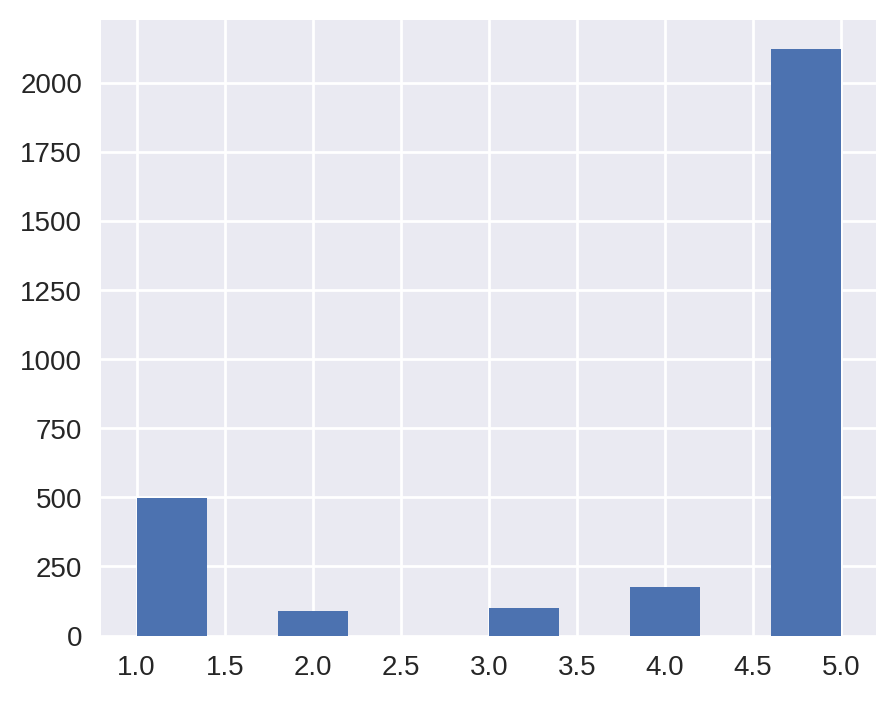

In [74]:
# Menampilkan review score ke dalam bar chart
plt.figure(figsize=[5,4])
plt.hist(df_alodokter_reviews['score'])
plt.show()

In [75]:
# Menambah kolom sentiment_rating
df_alodokter_reviews.loc[:, 'sentiment_rating'] = df_alodokter_reviews['score'].apply(lambda x: 'Positive' if x > 3 else ('Neutral' if x == 3 else 'Negative'))

In [76]:
df_alodokter_reviews.loc[:,["content", "score", "predicted_label", "sentiment_rating"]]

,content,score,predicted_label,sentiment_rating
0,informasi dan rekomendasi lengkap dan mudah di...,5,0,Positive
1,baik' untuk kesehatan,5,0,Positive
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,2,Positive
3,sangat baik dan memuaskan,5,0,Positive
4,sangat baik,5,1,Positive
...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,2,Negative
2996,sangat membantu ketika butuh jawaban segera,5,1,Positive
2997,good app with good price,5,1,Positive
2998,alhamdulillah resep obat yg diberikan dokter b...,5,0,Positive


In [77]:
# Mempersiapkan Mapping
label_mapping = {0: 'Positive', 1: 'Neutral', 2: 'Negative'}

# Mengganti predicted_label dengan sentiment
df_alodokter_reviews['predicted_sentiment'] = df_alodokter_reviews['predicted_label'].map(label_mapping)

In [78]:
# Hitung frekuensi untuk sentiment_rating dan predicted_sentiment
sentiment_counts = df_alodokter_reviews['sentiment_rating'].value_counts()
predicted_counts = df_alodokter_reviews['predicted_sentiment'].value_counts()

# Buat DataFrame untuk visualisasi
comparison_df = pd.DataFrame({
    'Actual': sentiment_counts,
    'Predicted': predicted_counts
}).fillna(0)  # Mengisi NaN dengan 0

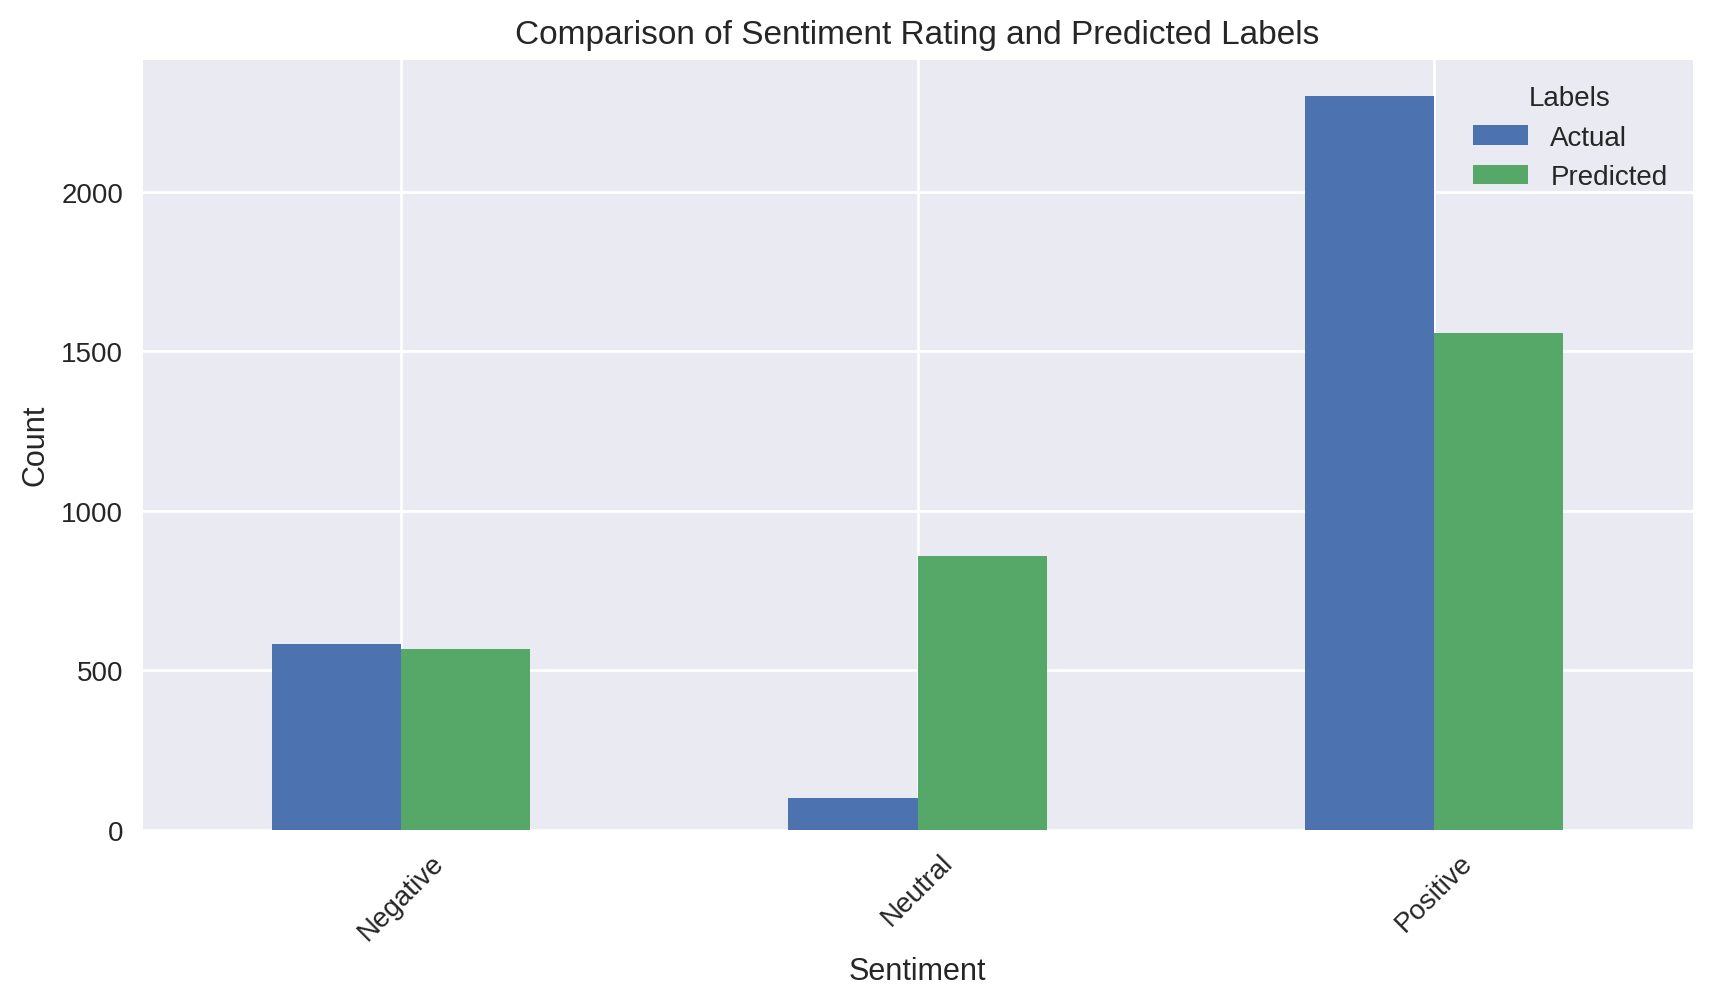

In [79]:
# Visualisasi
comparison_df.plot(kind='bar', figsize=(10, 5))
plt.title('Comparison of Sentiment Rating and Predicted Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Labels')
plt.show()

**Kesimpulan hasil visualisasi** di atas, yaitu:
1. Label rating (actual) dengan label yang diberikan dari hasil testing IndoBERT (predicted) dapat mendeteksi label negative dengan baik. Sedangkan untuk label neutral dan positive, model tidak dapat memprediksi dengan tepat. Terdapat perbedaan jumlah yang cukup jauh antara label neutral dan positive. Hal ini dapat disebabkan karena beberapa hal, seperti:

  -tingkat akurasi yang hanya bernilai 63.33%

  -terdapat ambiguitas teks antara ulasan neutral dan positive, sehingga model sulit dalam membedakannya.

# Text Analysis (Sebelum Stopwords)

In [80]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # Untuk fungsi word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [81]:
# Menghitung jumlah kata dengan tokenisasi menggunakan NLTK
df_alodokter_reviews['wordCount'] = df_alodokter_reviews['content'].apply(lambda x: len(word_tokenize(x)))
df_alodokter_reviews['uppercaseCharCount'] = [sum(char.isupper() for char in review) for review in df_alodokter_reviews['content']]
df_alodokter_reviews['specialCharCount'] = [sum(char in string.punctuation for char in review) for review in df_alodokter_reviews['content']]

In [82]:
df_alodokter_reviews.loc[:,["content","score","predicted_label", "sentiment_rating", "wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,predicted_label,sentiment_rating,wordCount,uppercaseCharCount,specialCharCount
0,informasi dan rekomendasi lengkap dan mudah di...,5,0,Positive,7,0,0
1,baik' untuk kesehatan,5,0,Positive,4,0,1
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,2,Positive,11,0,2
3,sangat baik dan memuaskan,5,0,Positive,4,0,0
4,sangat baik,5,1,Positive,2,0,0
...,...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,2,Negative,29,0,4
2996,sangat membantu ketika butuh jawaban segera,5,1,Positive,6,0,0
2997,good app with good price,5,1,Positive,5,0,0
2998,alhamdulillah resep obat yg diberikan dokter b...,5,0,Positive,46,0,3


In [83]:
# Fungsi untuk menghitung kata yang sering muncul
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

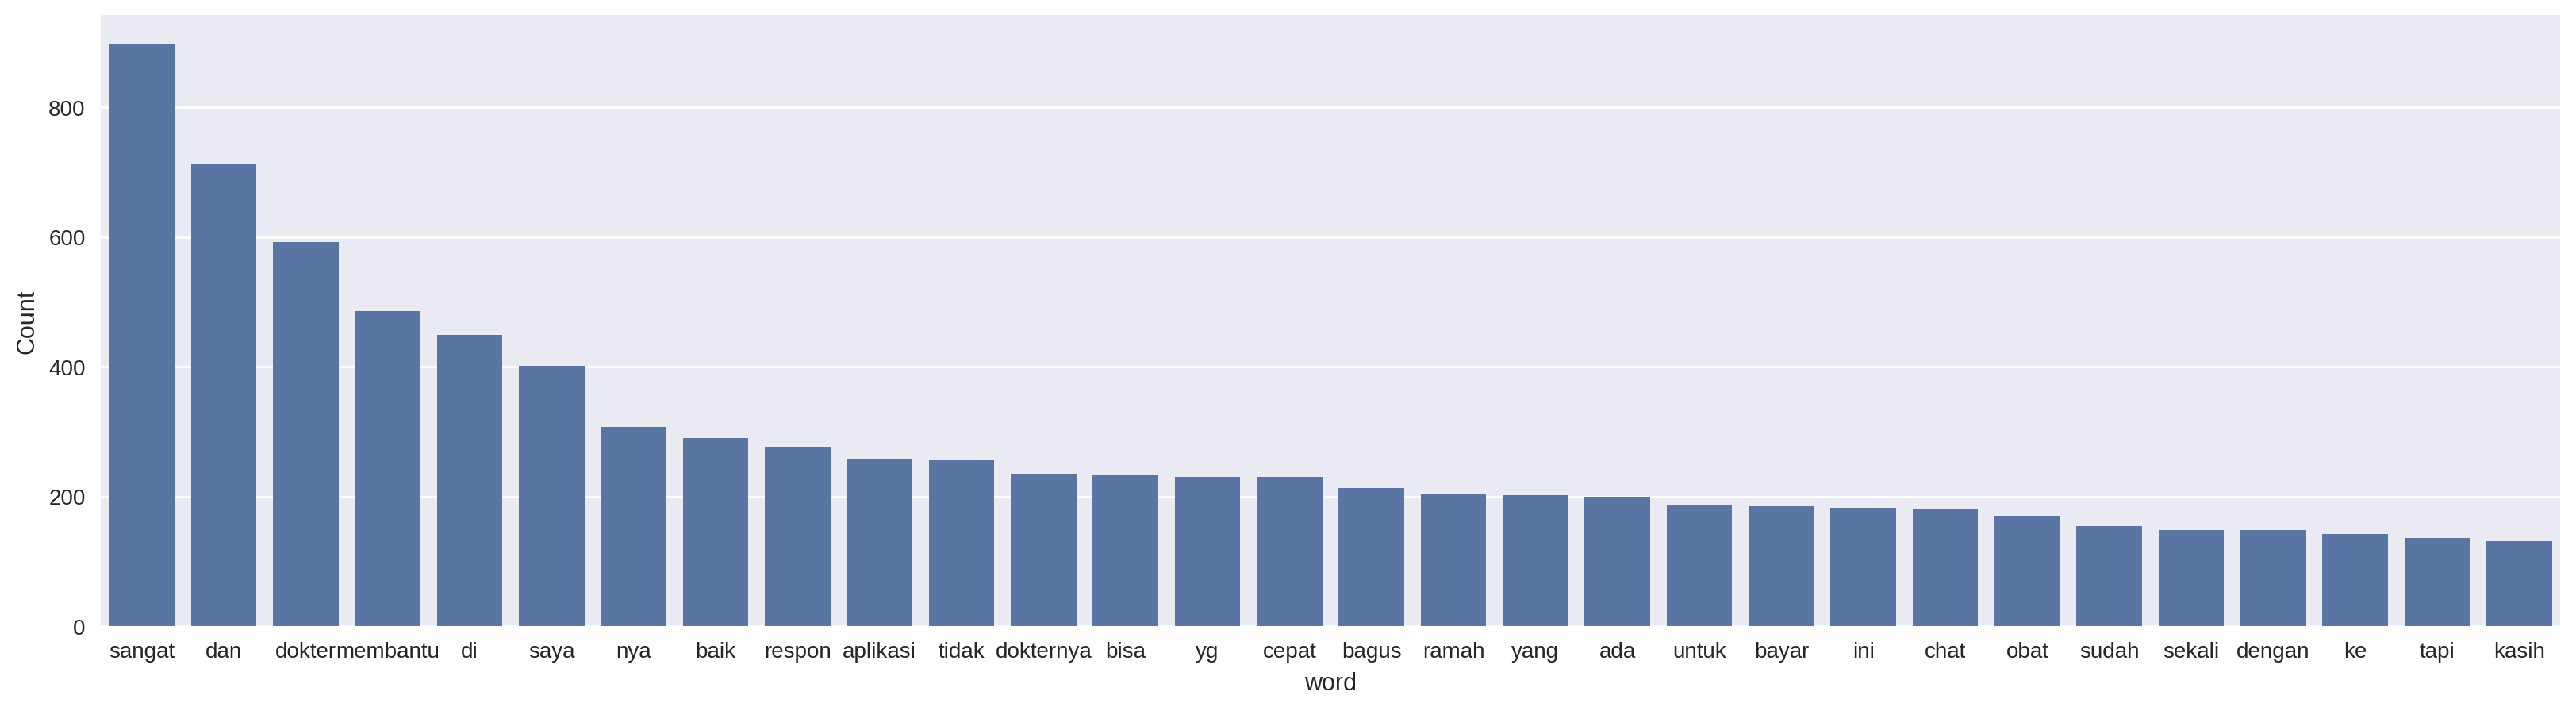

In [84]:
freq_words(df_alodokter_reviews['content'])

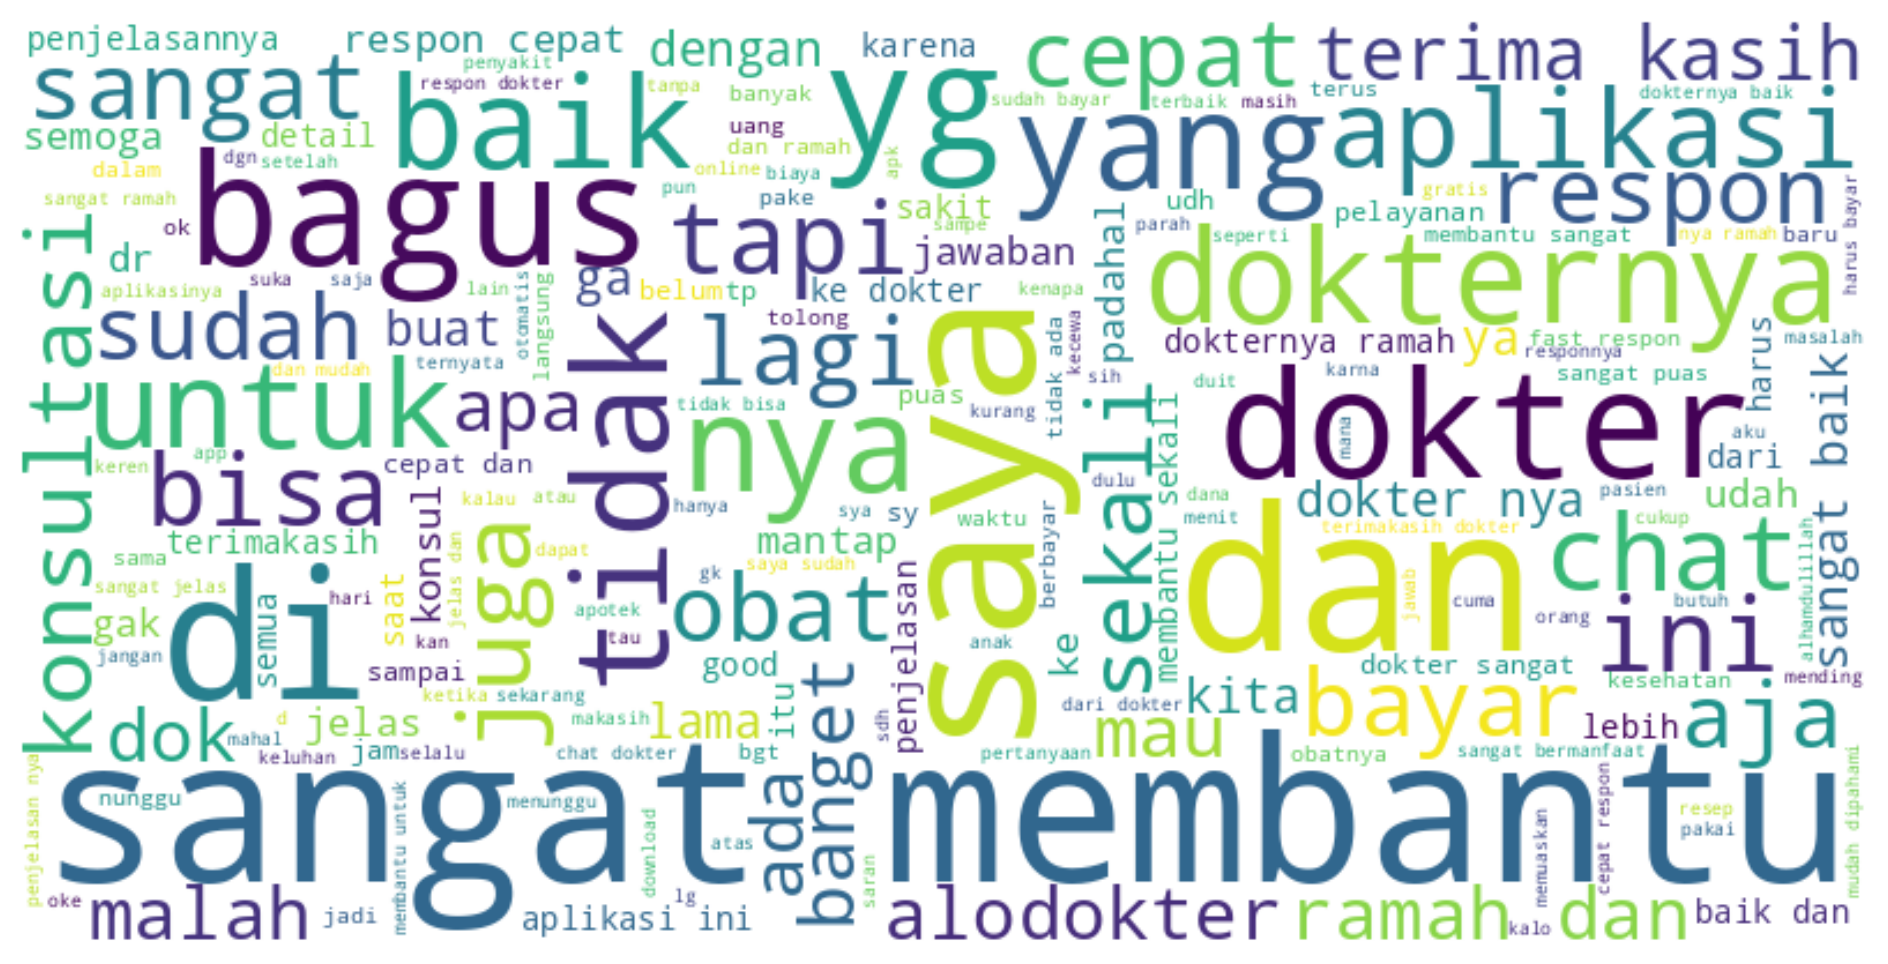

In [85]:
# Gabungkan semua kata dari kolom 'content' menjadi satu string
all_words_before = ' '.join(df_alodokter_reviews['content'])

# WordCloud sebelum menghapus stopwords
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(all_words_before)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.show()

In [86]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_alodokter_before_stopwords.csv'
df_alodokter.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_before_stopwords.csv


## Menghapus tanda baca

In [87]:
# Membuat dataframe baru
df_alodokter_stopwords = df_alodokter_reviews.loc[:,["content", "score", "predicted_label", "sentiment_rating", "wordCount"]]
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['content'].apply(
    lambda x: x.translate(str.maketrans("","",string.punctuation)))
df_alodokter_stopwords

,content,score,predicted_label,sentiment_rating,wordCount,review_without_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,0,Positive,7,informasi dan rekomendasi lengkap dan mudah di...
1,baik' untuk kesehatan,5,0,Positive,4,baik untuk kesehatan
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,2,Positive,11,terimakasih dok sehat sehat ya terimakasih ata...
3,sangat baik dan memuaskan,5,0,Positive,4,sangat baik dan memuaskan
4,sangat baik,5,1,Positive,2,sangat baik
...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,2,Negative,29,udah bayar mahal dokter online tp tidak meresp...
2996,sangat membantu ketika butuh jawaban segera,5,1,Positive,6,sangat membantu ketika butuh jawaban segera
2997,good app with good price,5,1,Positive,5,good app with good price
2998,alhamdulillah resep obat yg diberikan dokter b...,5,0,Positive,46,alhamdulillah resep obat yg diberikan dokter b...


# Menghapus Stopwords

In [88]:
import requests

# Unduh daftar stopwords dari URL
url = 'https://raw.githubusercontent.com/masdevid/ID-Stopwords/master/id.stopwords.02.01.2016.txt'
response = requests.get(url)

# Simpan daftar stopwords ke file lokal
with open('id_stopwords.txt', 'w') as file:
    file.write(response.text)

# Baca stopwords dari file
with open('id_stopwords.txt', 'r') as file:
    stopwords_id = file.read().splitlines()

# Menampilkan beberapa stopwords
print(f"Terdapat total {len(stopwords_id)} kata stopwords dalam bahasa Indonesia:")
print(stopwords_id[:10])  # Menampilkan 10 kata pertama dari daftar stopwords


Terdapat total 758 kata stopwords dalam bahasa Indonesia:
['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir']


In [89]:
# Fungsi untuk menghapus stopwords dari teks
def remove_stopwords(text, stopwords_list):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_list]
    return ' '.join(filtered_words)

In [90]:
# Menghapus stopwords dari kolom 'review_without_stopwords'
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

# Menampilkan hasil
df_alodokter_stopwords

,content,score,predicted_label,sentiment_rating,wordCount,review_without_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,0,Positive,7,informasi rekomendasi lengkap mudah dipahami
1,baik' untuk kesehatan,5,0,Positive,4,kesehatan
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,2,Positive,11,terimakasih dok sehat sehat ya terimakasih sar...
3,sangat baik dan memuaskan,5,0,Positive,4,memuaskan
4,sangat baik,5,1,Positive,2,
...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,2,Negative,29,udah bayar mahal dokter online tp merespon 30 ...
2996,sangat membantu ketika butuh jawaban segera,5,1,Positive,6,membantu butuh
2997,good app with good price,5,1,Positive,5,good app with good price
2998,alhamdulillah resep obat yg diberikan dokter b...,5,0,Positive,46,alhamdulillah resep obat yg dokter keluarga re...


In [92]:
# Fungsi untuk menghitung kata yang sering muncul
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})

    # Memilih kata yang paling sering muncul
    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(20, 5))
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel='Count')
    plt.show()

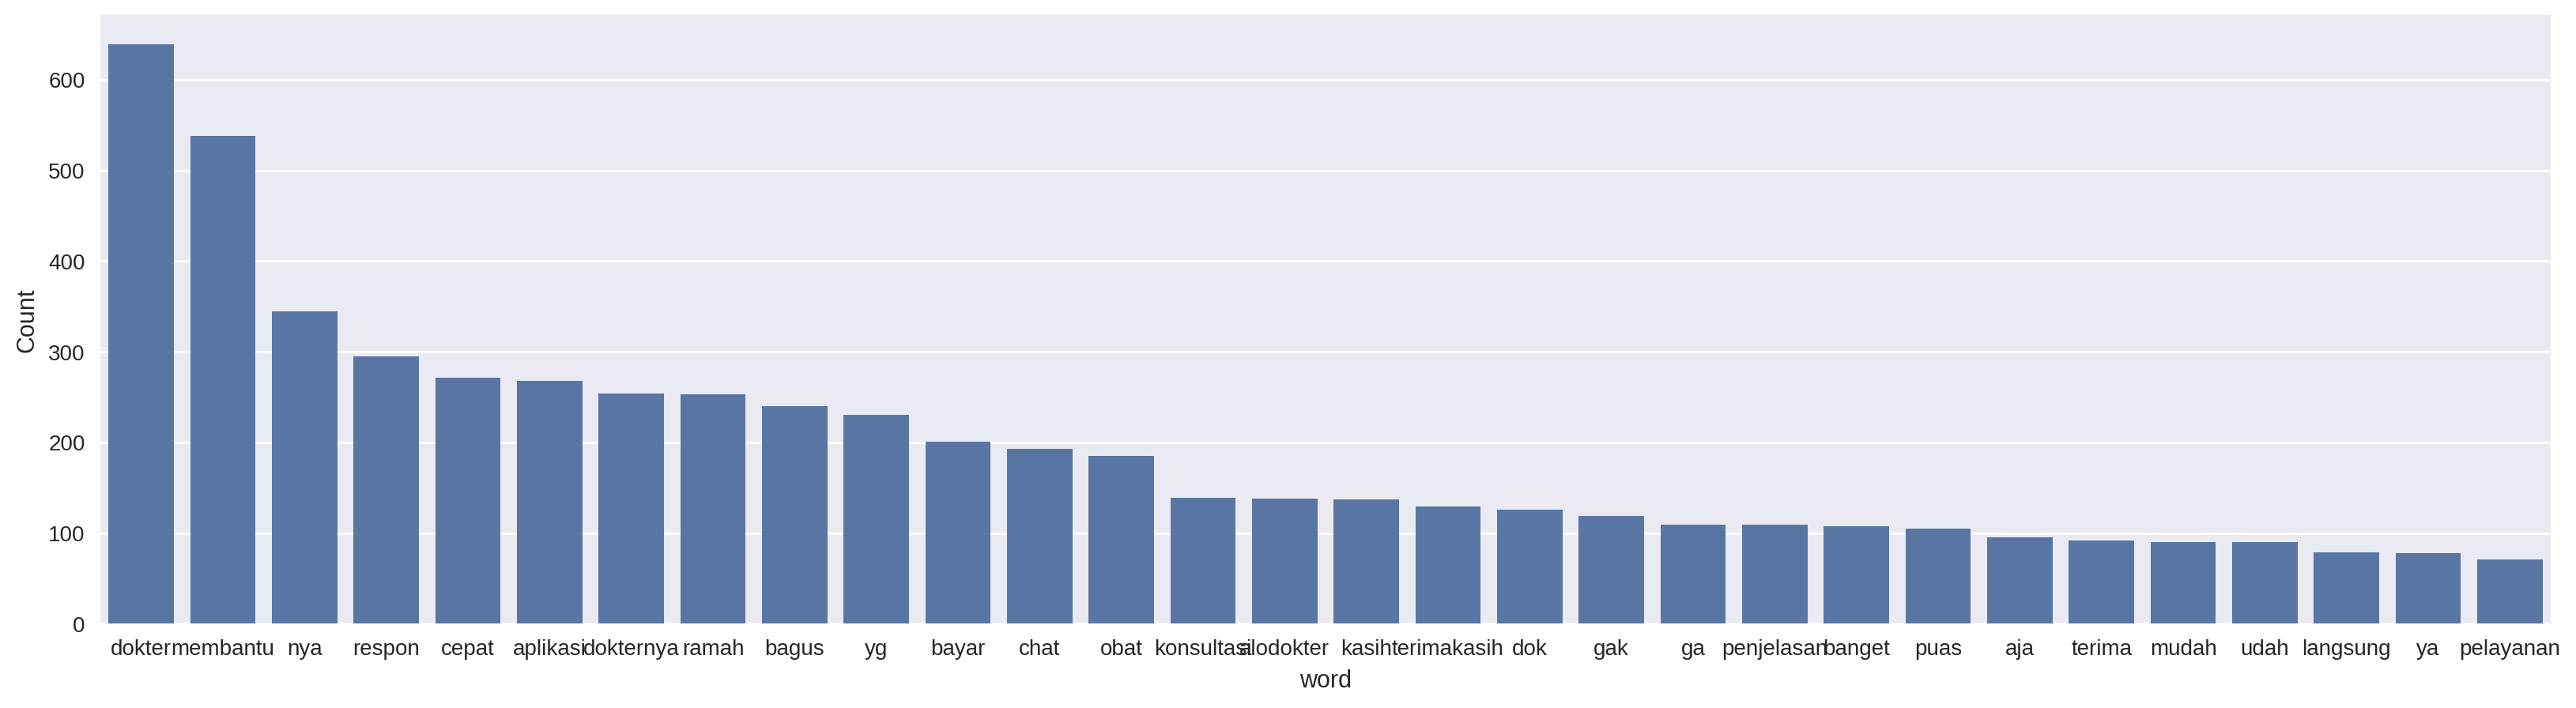

In [93]:
freq_words(df_alodokter_stopwords['review_without_stopwords'], terms=30)

In [94]:
stopwords_id = stopwords_id + ["nya", "yg", "dok", "gak", "ga", "aja", "ya"]

In [95]:
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

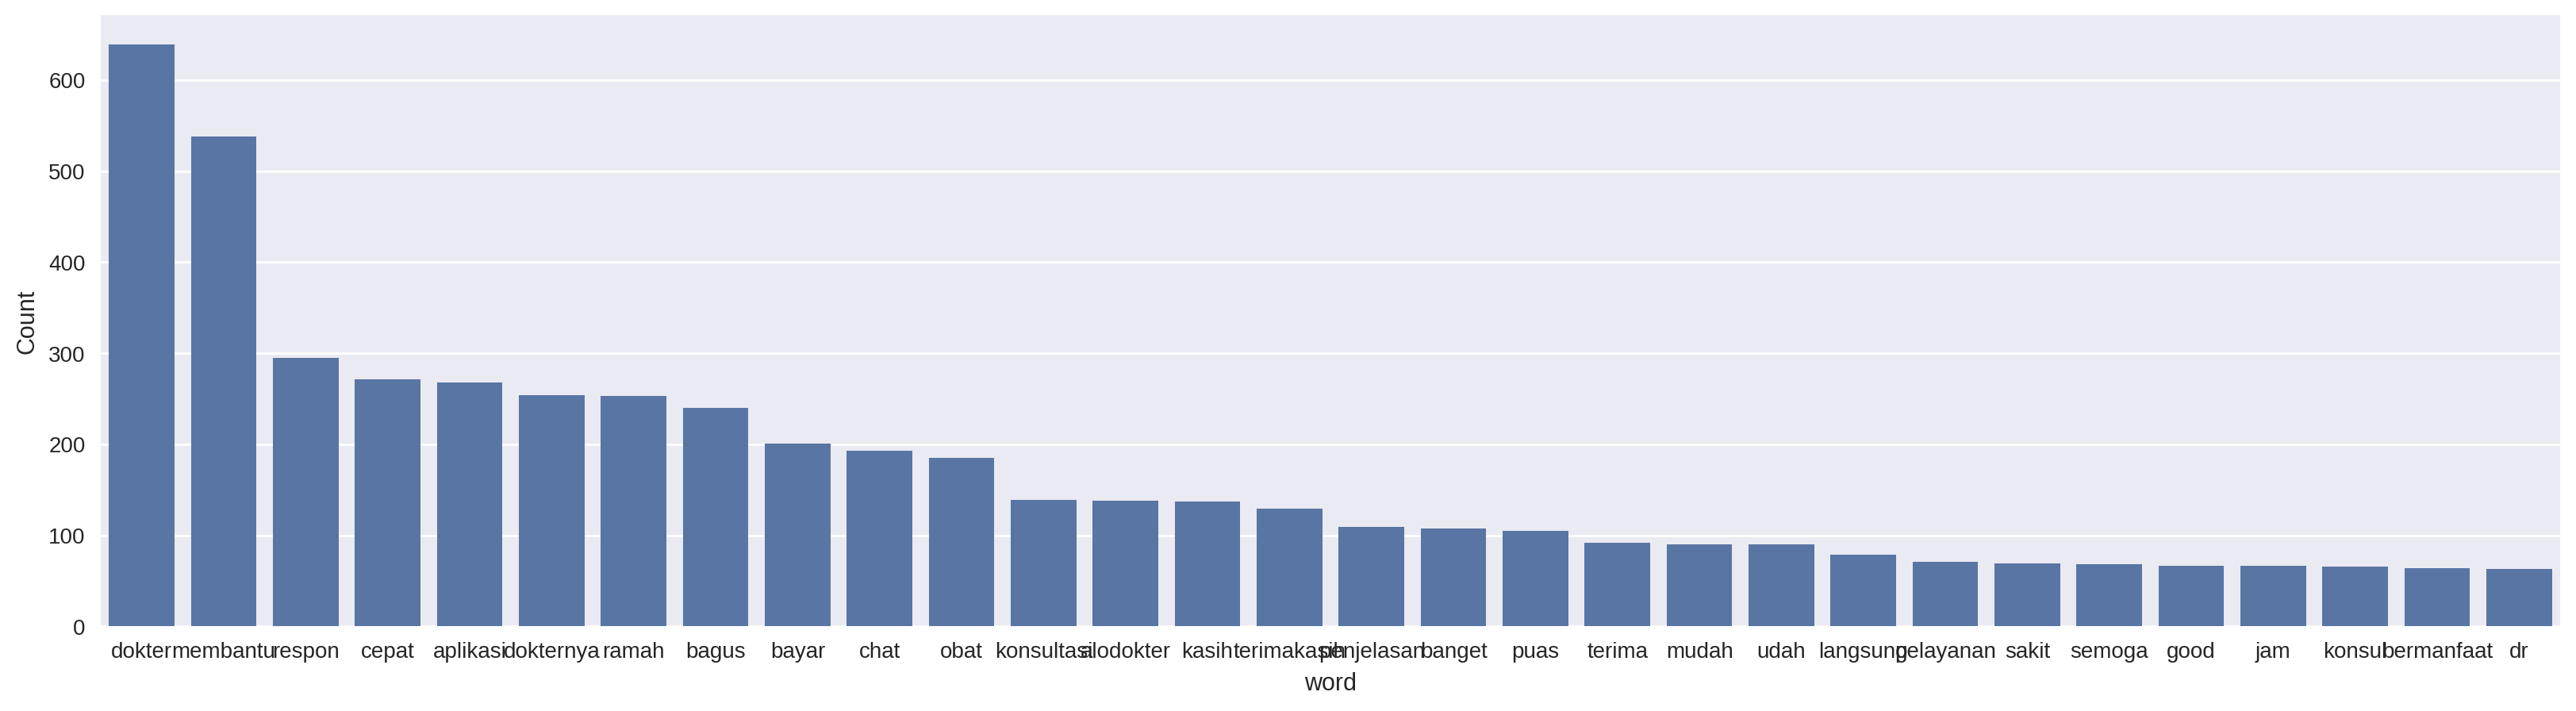

In [96]:
freq_words(df_alodokter_stopwords['review_without_stopwords'], terms=30)

In [97]:
stopwords_id = stopwords_id + ["dr"]
df_alodokter_stopwords['review_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

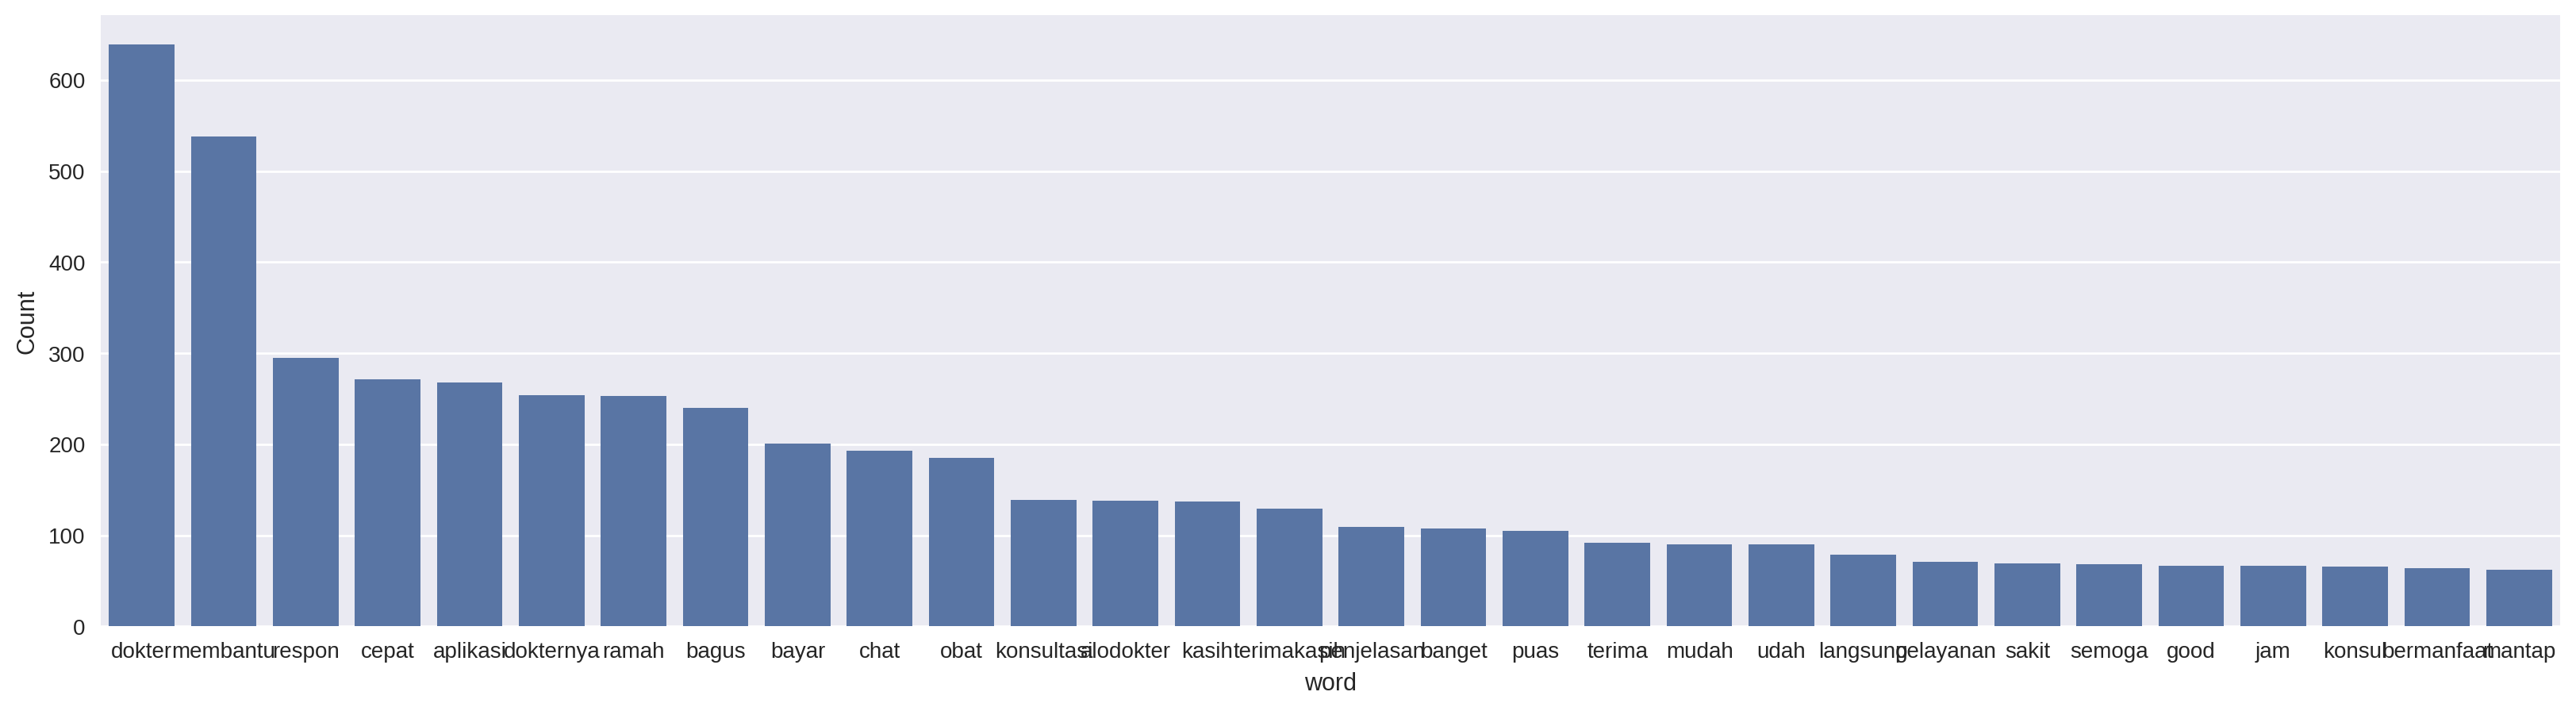

In [98]:
freq_words(df_alodokter_stopwords['review_without_stopwords'], terms=30)

# Text Analysis (Setelah Stopwords)

In [99]:
# Menghitung jumlah kata setelah menghapus stopwords
df_alodokter_stopwords['wordCount_after_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(
    lambda x: len(x.split())
)

In [100]:
df_alodokter_stopwords.loc[:,["content","score","predicted_label", "sentiment_rating","wordCount","review_without_stopwords", "wordCount_after_stopwords"]]

,content,score,predicted_label,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,0,Positive,7,informasi rekomendasi lengkap mudah dipahami,5
1,baik' untuk kesehatan,5,0,Positive,4,kesehatan,1
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,2,Positive,11,terimakasih sehat sehat terimakasih saran sara...,6
3,sangat baik dan memuaskan,5,0,Positive,4,memuaskan,1
4,sangat baik,5,1,Positive,2,,0
...,...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,2,Negative,29,udah bayar mahal dokter online tp merespon 30 ...,19
2996,sangat membantu ketika butuh jawaban segera,5,1,Positive,6,membantu butuh,2
2997,good app with good price,5,1,Positive,5,good app with good price,5
2998,alhamdulillah resep obat yg diberikan dokter b...,5,0,Positive,46,alhamdulillah resep obat dokter keluarga repot...,20


In [101]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_alodokter_after_stopwords.csv'
df_alodokter_stopwords.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_after_stopwords.csv


# Stemming

Stemming berguna untuk memotong akhir kata/imbuhan, sehingga kata kembali menjadi bentuk dasarnya.

In [102]:
# Mengunduh library untuk stemming Bahasa Indonesia
!pip install PySastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 4.6 MB/s eta 0:00:00


In [103]:
# Import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [104]:
# Fungsi untuk stemming
def stemming_indonesia(text):
    if text is not None:
        # Lakukan stemming dan kembalikan hasilnya
        return stemmer.stem(text)
    return ''

In [105]:
# Terapkan stemming pada kolom 'review_without_stopwords'
df_alodokter_stopwords['review_stem_without_stopwords'] = df_alodokter_stopwords['review_without_stopwords'].apply(lambda x: stemming_indonesia(x))
# Menampilkan hasil untuk beberapa baris
df_alodokter_stopwords.loc[0:3, ['review_without_stopwords', 'review_stem_without_stopwords']]

,review_without_stopwords,review_stem_without_stopwords
0,informasi rekomendasi lengkap mudah dipahami,informasi rekomendasi lengkap mudah paham
1,kesehatan,sehat
2,terimakasih sehat sehat terimakasih saran sara...,terimakasih sehat sehat terimakasih saran saran
3,memuaskan,muas


In [106]:
df_alodokter_stopwords = df_alodokter_stopwords[df_alodokter_stopwords['review_without_stopwords'] != '']

In [107]:
df_alodokter_stopwords[df_alodokter_stopwords['review_without_stopwords'] == '']

,content,score,predicted_label,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords,review_stem_without_stopwords


In [ ]:
# Menghapus semua baris yang memiliki nilai None di seluruh DataFrame
df_alodokter_stopwords = df_alodokter_stopwords.dropna()

In [108]:
df_alodokter_stopwords

,content,score,predicted_label,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords,review_stem_without_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,0,Positive,7,informasi rekomendasi lengkap mudah dipahami,5,informasi rekomendasi lengkap mudah paham
1,baik' untuk kesehatan,5,0,Positive,4,kesehatan,1,sehat
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,2,Positive,11,terimakasih sehat sehat terimakasih saran sara...,6,terimakasih sehat sehat terimakasih saran saran
3,sangat baik dan memuaskan,5,0,Positive,4,memuaskan,1,muas
5,respon cepat... pelayanan baik sekali,5,0,Positive,6,respon cepat pelayanan,3,respon cepat layan
...,...,...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,2,Negative,29,udah bayar mahal dokter online tp merespon 30 ...,19,udah bayar mahal dokter online tp merespon 30 ...
2996,sangat membantu ketika butuh jawaban segera,5,1,Positive,6,membantu butuh,2,bantu butuh
2997,good app with good price,5,1,Positive,5,good app with good price,5,good app with good price
2998,alhamdulillah resep obat yg diberikan dokter b...,5,0,Positive,46,alhamdulillah resep obat dokter keluarga repot...,20,alhamdulillah resep obat dokter keluarga repot...


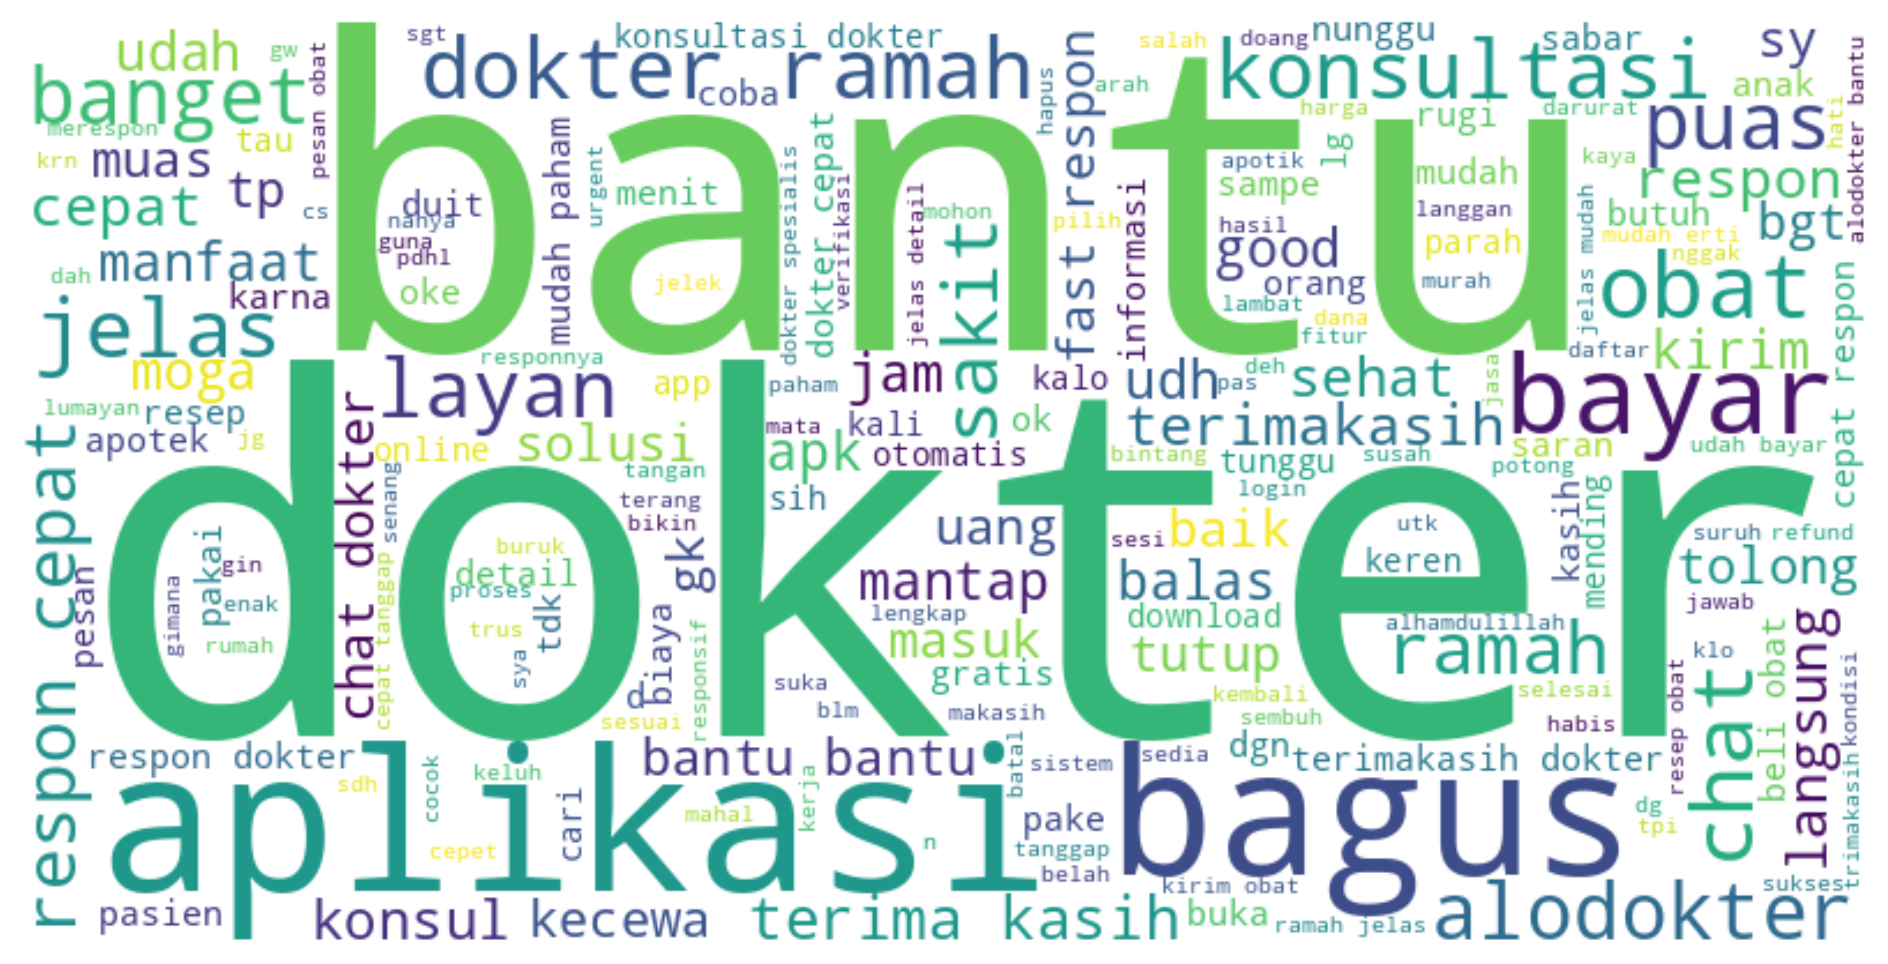

In [109]:
# Gabungkan semua kata dari kolom 'review_stem_without_stopwords' menjadi satu string
text = ' '.join(df_alodokter_stopwords['review_stem_without_stopwords'])

# WordCloud setelah menghapus stopwords dan stemming
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [110]:
# Hasil akhir
df_alodokter_stopwords.loc[:,["content","score","sentiment_rating","wordCount","review_without_stopwords", "wordCount_after_stopwords", 'review_stem_without_stopwords']]

,content,score,sentiment_rating,wordCount,review_without_stopwords,wordCount_after_stopwords,review_stem_without_stopwords
0,informasi dan rekomendasi lengkap dan mudah di...,5,Positive,7,informasi rekomendasi lengkap mudah dipahami,5,informasi rekomendasi lengkap mudah paham
1,baik' untuk kesehatan,5,Positive,4,kesehatan,1,sehat
2,"terimakasih dok, sehat sehat ya, terimakasih a...",5,Positive,11,terimakasih sehat sehat terimakasih saran sara...,6,terimakasih sehat sehat terimakasih saran saran
3,sangat baik dan memuaskan,5,Positive,4,memuaskan,1,muas
5,respon cepat... pelayanan baik sekali,5,Positive,6,respon cepat pelayanan,3,respon cepat layan
...,...,...,...,...,...,...,...
2995,udah bayar mahal. dokter online tp tidak meres...,1,Negative,29,udah bayar mahal dokter online tp merespon 30 ...,19,udah bayar mahal dokter online tp merespon 30 ...
2996,sangat membantu ketika butuh jawaban segera,5,Positive,6,membantu butuh,2,bantu butuh
2997,good app with good price,5,Positive,5,good app with good price,5,good app with good price
2998,alhamdulillah resep obat yg diberikan dokter b...,5,Positive,46,alhamdulillah resep obat dokter keluarga repot...,20,alhamdulillah resep obat dokter keluarga repot...


In [111]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_alodokter_after_stopwords_stemming.csv'
df_alodokter_stopwords.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_alodokter_after_stopwords_stemming.csv
